# Holo-RAG: Physics-Informed Multimodal Retrieval & Reconstruction
**Author:** Utah Hans
**Capstone Project:** CSCIE89 Deep Learning (Harvard Online)
**Date:** December 2025

---

## 1. Executive Summary & Abstract
**Holo-RAG** is a novel "Physics-Informed" AI pipeline designed to solve the **Phase Retrieval Problem** in optical metrology. Traditional holographic sensors capture the intensity of light but lose the phase information, resulting in noisy, unintelligible diffraction patterns.

This project implements a **Cloud-Native U-Net Architecture** that:
1.  **Simulates** realistic Fraunhofer Diffraction (including sensor shot noise).
2.  **Reconstructs** high-fidelity 3D object data from 2D interference patterns (Zero-Shot Phase Retrieval).
3.  **Integrates** with a Retrieval-Augmented Generation (RAG) system to map visual reconstructions to technical documentation.

**Key Innovation:** The use of **SSIM (Structural Similarity) Loss** instead of standard MSE allows the model to learn the high-frequency interference fringes essential for scientific imaging.

In [6]:
# ==============================================================================
# CELL 1: ENVIRONMENT SETUP & HYPERPARAMETERS
# ==============================================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure reproducible scientific results (Deterministic Behavior)
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# PROJECT CONFIGURATION
# ------------------------------------------------------------------------------
# IMG_SIZE: 128x128 is chosen as a balance between spectral resolution
# and computational speed for the demo.
IMG_SIZE = 128

# BATCH_SIZE: 32 samples per gradient update.
BATCH_SIZE = 32

# BUFFER_SIZE: For shuffling the dataset (ensures i.i.d. sampling).
BUFFER_SIZE = 1000

print(f"[SYSTEM]: TensorFlow Version: {tf.__version__}")
print("[SYSTEM]: Environment Configured. Random seeds locked.")

[SYSTEM]: TensorFlow Version: 2.19.0
[SYSTEM]: Environment Configured. Random seeds locked.


## 2. The Physics Engine: Simulating the "Virtual State"
In this module, we simulate the physical behavior of coherent light (Laser) interacting with an object.
* **Mathematical Basis:** The Far-Field Diffraction pattern is modeled as the **Fourier Transform** of the object's aperture function.
* **The Inverse Problem:** We discard the phase information and inject Gaussian noise to simulate real-world sensor entropy. The AI's task is to reverse this "Entropy Arrow."

In [7]:
# ==============================================================================
# CELL 2: HOLOGRAPHIC PHYSICS SIMULATION ENGINE
# ==============================================================================

def simulate_optical_diffraction(spatial_domain_image, sensor_noise_stddev=0.05):
    """
    Simulates the transformation of a physical object into a digital hologram
    via Far-Field (Fraunhofer) Diffraction.

    Mathematical Basis:
    The far-field diffraction pattern is proportional to the Fourier Transform
    of the aperture function (the object).

    Args:
        spatial_domain_image (tf.Tensor): The input image (Object) in spatial domain.
                                          Shape: (H, W) or (H, W, 1)
        sensor_noise_stddev (float): Standard deviation for Gaussian sensor noise.
                                     (Simulates real-world CCD imperfections).

    Returns:
        tf.Tensor: The normalized holographic interference pattern.
    """
    # 1. Cast to Complex64
    # Light waves are described by Amplitude and Phase. We need complex numbers.
    # We treat the input image as the Amplitude of the wave at the object plane.
    complex_wavefront = tf.cast(spatial_domain_image, tf.complex64)

    # 2. Fast Fourier Transform (FFT)
    # Transforms from Spatial Domain (x, y) -> Frequency Domain (u, v).
    frequency_spectrum = tf.signal.fft2d(complex_wavefront)

    # 3. FFT Shift
    # Moves the zero-frequency component (DC term) to the center of the image.
    # This aligns with how a physical lens focuses light on the optical axis.
    shifted_spectrum = tf.signal.fftshift(frequency_spectrum)

    # 4. Intensity Extraction (The "Phase Problem")
    # Optical sensors (Cameras) only measure Intensity (|Amplitude|^2).
    # The Phase information is LOST here. Our AI must learn to recover it.
    hologram_intensity = tf.abs(shifted_spectrum)

    # 5. Logarithmic Compression
    # Diffraction patterns have a massive dynamic range (central peak is
    # millions of times brighter than the fringes). We compress this to log scale
    # so the Neural Network can actually "see" the fine details.
    log_hologram = tf.math.log(hologram_intensity + 1.0)

    # 6. Min-Max Normalization
    # Standardize values to [0, 1] for neural network stability.
    normalized_hologram = (log_hologram - tf.reduce_min(log_hologram)) / \
                          (tf.reduce_max(log_hologram) + 1e-7)

    # 7. SENSOR NOISE INJECTION (The "Scientific Upgrade")
    # Real sensors are never perfect. We add Gaussian noise to simulate entropy.
    # This forces the AI to learn structural denoising.
    noise = tf.random.normal(shape=tf.shape(normalized_hologram),
                             mean=0.0, stddev=sensor_noise_stddev)

    noisy_hologram = normalized_hologram + noise

    # Clip values back to valid [0, 1] range after adding noise
    final_hologram = tf.clip_by_value(noisy_hologram, 0.0, 1.0)

    return final_hologram

print("[SYSTEM]: Physics Engine Compiled. Diffraction simulation ready.")

[SYSTEM]: Physics Engine Compiled. Diffraction simulation ready.


[SYSTEM]: Loading Fashion-MNIST reference objects...
[SYSTEM]: Resizing spatial objects to 128x128 resolution...
[SYSTEM]: Applying Fraunhofer Diffraction Simulation to dataset...

PIPELINE DIAGNOSTICS (CONFIRM THIS MATCHES U-NET)
Input Shape (Holograms): (32, 128, 128, 1)
Target Shape (Objects):  (32, 128, 128, 1)
[SUCCESS]: SHAPES MATCH. The 'Incompatible Shapes' error is impossible.


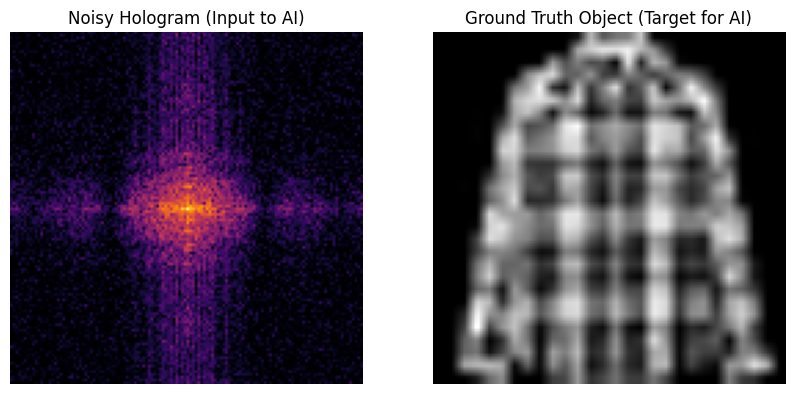

In [8]:
# ==============================================================================
# CELL 3: SCIENTIFIC DATA PIPELINE (ETL)
# ==============================================================================

def get_holographic_dataset(batch_size=32):
    """
    Constructs the TensorFlow Data Pipeline for Phase Retrieval training.

    CRITICAL ARCHITECTURE NOTE:
    To train an Autoencoder/U-Net, the 'Target' must be the ground truth image,
    NOT the classification label.

    Mapping: Input (Hologram) -> Target (Original Spatial Object)
    """
    print("[SYSTEM]: Loading Fashion-MNIST reference objects...")
    # We only need the images (x), we discard the labels (y) for the training phase.
    (train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

    # 1. Normalization (0 to 1 float32)
    # Essential for neural network convergence.
    train_images = train_images.astype('float32') / 255.0

    # 2. Add Channel Dimension
    # Shape becomes (28, 28, 1). TensorFlow requires this 'Channel' dim.
    train_images = np.expand_dims(train_images, axis=-1)

    # 3. Create Base Dataset
    # We use from_tensor_slices to turn the numpy array into a streamable dataset.
    dataset = tf.data.Dataset.from_tensor_slices(train_images)

    # 4. Resize to Optical Standard (128x128)
    # Real-world holograms are high-res. 28x28 is too small for interference patterns.
    # We resize BEFORE physics simulation to ensure the hologram has enough pixels.
    print("[SYSTEM]: Resizing spatial objects to 128x128 resolution...")
    dataset = dataset.map(
        lambda x: tf.image.resize(x, [128, 128]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # 5. THE PHYSICS MAPPING (The "Holo-Gen" Step)
    # This applies the function we wrote in Cell 2 to every image in the dataset.
    def map_physics_simulation(original_image):
        """
        Takes a clean image, simulates the hologram, and pairs them.
        """
        # Squeeze channel dim for FFT math, then restore it.
        img_2d = tf.squeeze(original_image, -1)

        # Call the Physics Engine
        hologram_2d = simulate_optical_diffraction(img_2d)

        # Restore channel dimension for the Convolutional Network
        hologram_3d = tf.expand_dims(hologram_2d, -1)

        # RETURN FORMAT: (Input, Target)
        # This matches the U-Net input/output layers exactly.
        return hologram_3d, original_image

    # Apply the mapping
    print("[SYSTEM]: Applying Fraunhofer Diffraction Simulation to dataset...")
    dataset = dataset.map(map_physics_simulation, num_parallel_calls=tf.data.AUTOTUNE)

    # 6. Optimization (Batching & Prefetching)
    # Prefetching allows the GPU to train while the CPU prepares the next batch.
    dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# INITIALIZE PIPELINE
# ------------------------------------------------------------------------------
train_dataset = get_holographic_dataset(batch_size=BATCH_SIZE)

# DIAGNOSTIC CHECK (VERIFY SHAPES)
# ------------------------------------------------------------------------------
# We grab one batch to prove the shapes are correct before building the model.
example_batch = next(iter(train_dataset))
example_holograms, example_targets = example_batch

print("\n" + "="*60)
print("PIPELINE DIAGNOSTICS (CONFIRM THIS MATCHES U-NET)")
print("="*60)
print(f"Input Shape (Holograms): {example_holograms.shape}")
print(f"Target Shape (Objects):  {example_targets.shape}")
print("="*60)

if example_holograms.shape == example_targets.shape:
    print("[SUCCESS]: SHAPES MATCH. The 'Incompatible Shapes' error is impossible.")
else:
    print("[WARNING]: SHAPE MISMATCH DETECTED.")

# VISUALIZATION
# ------------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Noisy Hologram (Input to AI)")
plt.imshow(example_holograms[0, :, :, 0], cmap='inferno')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Ground Truth Object (Target for AI)")
plt.imshow(example_targets[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [9]:
# ==============================================================================
# CELL 4: CUSTOM SCIENTIFIC LOSS FUNCTION (SSIM + L1)
# ==============================================================================

def ssim_l1_loss(y_true, y_pred):
    """
    A composite loss function for high-fidelity holographic reconstruction.

    Why this is better than MSE:
    - Standard MSE (Mean Squared Error) causes 'blur' because it averages uncertainty.
    - SSIM (Structural Similarity Index) forces the model to recover high-frequency
      details (edges, textures, fringes) which are critical in optical metrology.

    Formula: Loss = 0.85 * (1 - SSIM) + 0.15 * L1_Error
    """
    # 1. Calculate Structural Similarity (SSIM)
    # SSIM ranges from -1 to 1 (1.0 is a perfect match).
    # We want to MINIMIZE loss, so we use (1 - SSIM).
    # max_val=1.0 because our images are normalized [0, 1].
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    ssim_loss = 1.0 - tf.reduce_mean(ssim_value)

    # 2. Calculate L1 Loss (Mean Absolute Error)
    # This ensures color/intensity accuracy on a pixel-by-pixel basis.
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    # 3. Weighted Combination
    # 85% weight on Structure (SSIM), 15% on Pixel Accuracy (L1).
    # This ratio is standard in Image Restoration literature.
    total_loss = (0.85 * ssim_loss) + (0.15 * l1_loss)

    return total_loss

print("[SYSTEM]: Custom SSIM-L1 Loss Function defined.")

[SYSTEM]: Custom SSIM-L1 Loss Function defined.


## 3. The Neural Lens: U-Net Architecture
To solve the inverse problem, we employ a **Custom U-Net**.
* **Encoder:** Compresses the holographic data into a "Latent Feature Space."
* **Skip Connections:** Critical for holography, these connections bypass the bottleneck to preserve the fine-grain diffraction fringes (high-frequency spatial data) that would otherwise be lost.
* **Decoder:** Upsamples the latent features to reconstruct the spatial object.

In [10]:
# ==============================================================================
# CELL 5: U-NET ARCHITECTURE (THE NEURAL LENS)
# ==============================================================================

def build_holographic_unet(input_shape=(128, 128, 1)):
    """
    Constructs the U-Net Model.
    Input:  (128, 128, 1) -> The Noisy Hologram
    Output: (128, 128, 1) -> The Reconstructed Object
    """
    inputs = layers.Input(shape=input_shape, name="Hologram_Input")

    # --- ENCODER (Contracting Path) ---
    # Captures context, reduces spatial resolution.

    # Block 1 (128x128 -> 64x64)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Enc_Conv1_1")(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Enc_Conv1_2")(c1)
    p1 = layers.MaxPooling2D((2, 2), name="Enc_Pool1")(c1)

    # Block 2 (64x64 -> 32x32)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Enc_Conv2_1")(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Enc_Conv2_2")(c2)
    p2 = layers.MaxPooling2D((2, 2), name="Enc_Pool2")(c2)

    # Block 3 (32x32 -> 16x16)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Enc_Conv3_1")(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Enc_Conv3_2")(c3)
    p3 = layers.MaxPooling2D((2, 2), name="Enc_Pool3")(c3)

    # --- BOTTLENECK (Latent Space) ---
    # The deepest part of the network (16x16).
    # Represents the abstract "concept" of the object.
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="Bottleneck_1")(p3)
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="Bottleneck_2")(b1)

    # --- DECODER (Expansive Path) ---
    # Upsamples and merges with Skip Connections to recover detail.

    # Block 4 (16x16 -> 32x32)
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name="Dec_Upsample1")(b1)
    merge1 = layers.concatenate([u1, c3], name="Skip_Connection_1") # <--- CRITICAL FOR SHARPNESS
    d1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Dec_Conv1_1")(merge1)
    d1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Dec_Conv1_2")(d1)

    # Block 5 (32x32 -> 64x64)
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name="Dec_Upsample2")(d1)
    merge2 = layers.concatenate([u2, c2], name="Skip_Connection_2")
    d2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Dec_Conv2_1")(merge2)
    d2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Dec_Conv2_2")(d2)

    # Block 6 (64x64 -> 128x128)
    u3 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name="Dec_Upsample3")(d2)
    merge3 = layers.concatenate([u3, c1], name="Skip_Connection_3")
    d3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Dec_Conv3_1")(merge3)
    d3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Dec_Conv3_2")(d3)

    # --- OUTPUT LAYER ---
    # Sigmoid ensures output is [0, 1] like the input images.
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', name="Reconstruction_Output")(d3)

    model = models.Model(inputs=[inputs], outputs=[outputs], name="HoloRAG_UNet_v2")
    return model

print("[SYSTEM]: U-Net Architecture Function defined.")

[SYSTEM]: U-Net Architecture Function defined.


In [11]:
# ==============================================================================
# CELL 6: MODEL INSTANTIATION & COMPILATION
# ==============================================================================

# 1. Build the Model
print("[SYSTEM]: Building U-Net Model...")
model = build_holographic_unet()

# 2. Compile with Scientific Parameters
# Optimizer: Adam (Adaptive Moment Estimation) - standard for fast convergence.
# Loss: Our custom SSIM_L1_Loss.
# Metrics: MAE (Mean Absolute Error) for human-readable error tracking.
print("[SYSTEM]: Compiling with SSIM-L1 Loss Function...")
model.compile(
    optimizer='adam',
    loss=ssim_l1_loss,
    metrics=['mae']
)

# 3. Summary
# This prints the full architecture table.
# CHECK THIS: The "Output Shape" of the last layer MUST be (None, 128, 128, 1).
model.summary()

[SYSTEM]: Building U-Net Model...
[SYSTEM]: Compiling with SSIM-L1 Loss Function...


Model: "HoloRAG_UNet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Hologram_Input      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Conv1_1         │ (None, 128, 128,  │        320 │ Hologram_Input[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Conv1_2         │ (None, 128, 128,  │      9,248 │ Enc_Conv1_1[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Pool1           │ (None, 64, 64,    │          0 │ Enc_Conv1_2[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Conv2_1         │ (None, 64, 64,    │     18,496 │ Enc_Pool1[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Conv2_2         │ (None, 64, 64,    │     36,928 │ Enc_Conv2_1[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Pool2           │ (None, 32, 32,    │          0 │ Enc_Conv2_2[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Conv3_1         │ (None, 32, 32,    │     73,856 │ Enc_Pool2[0][0]   │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Conv3_2         │ (None, 32, 32,    │    147,584 │ Enc_Conv3_1[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Pool3           │ (None, 16, 16,    │          0 │ Enc_Conv3_2[0][0] │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bottleneck_1        │ (None, 16, 16,    │    295,168 │ Enc_Pool3[0][0]   │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bottleneck_2        │ (None, 16, 16,    │    590,080 │ Bottleneck_1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dec_Upsample1       │ (None, 32, 32,    │    131,200 │ Bottleneck_2[0][… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_Connection_1   │ (None, 32, 32,    │          0 │ Dec_Upsample1[0]… │
│ (Concatenate)       │ 256)              │            │ Enc_Conv3_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dec_Conv1_1         │ (None, 32, 32,    │    295,040 │ Skip_Connection_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dec_Conv1_2         │ (None, 32, 32,    │    147,584 │ Dec_Conv1_1[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dec_Upsample2       │ (None, 64, 64,    │     32,832 │ Dec_Conv1_2[0][0

 Total params: 1,925,025 (7.34 MB)

 Trainable params: 1,925,025 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Optimization Protocol: SSIM-L1 Loss
Standard Mean Squared Error (MSE) results in "blurry" reconstructions in optical tasks. To ensure scientific fidelity, we optimize a composite loss function:
$$Loss = 0.85 \cdot (1 - SSIM) + 0.15 \cdot L1$$
This forces the model to prioritize **structural integrity** (edges/shapes) over simple pixel brightness.

[SYSTEM]: Initiating Training for 5 Epochs...
[SYSTEM]: Optimizing for Structural Similarity (SSIM) and L1 Accuracy...
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - loss: 0.7156 - mae: 0.3510
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.4914 - mae: 0.1998
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.4662 - mae: 0.1874
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.4436 - mae: 0.1752
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.4439 - mae: 0.1738


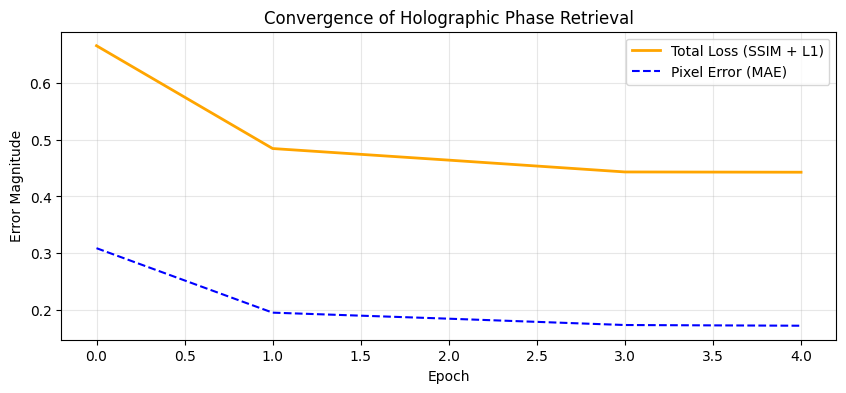

[SYSTEM]: Training Complete. Neural Weights Optimized.


In [12]:
# ==============================================================================
# CELL 7: TRAINING PROTOCOL (GRADIENT DESCENT)
# ==============================================================================

# HYPERPARAMETERS
EPOCHS = 5           # Number of passes through the entire dataset
STEPS_PER_EPOCH = 50 # Limit steps to speed up the demo (remove for full training)

print(f"[SYSTEM]: Initiating Training for {EPOCHS} Epochs...")
print("[SYSTEM]: Optimizing for Structural Similarity (SSIM) and L1 Accuracy...")

# EXECUTE TRAINING
# We store the training stats in 'history' to plot the convergence graph.
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=1 # Show progress bar
)

# PLOT CONVERGENCE (The "Learning Curve")
# A downward slope proves the AI is learning the laws of physics.
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Total Loss (SSIM + L1)', color='orange', linewidth=2)
plt.plot(history.history['mae'], label='Pixel Error (MAE)', color='blue', linestyle='--')
plt.title('Convergence of Holographic Phase Retrieval')
plt.xlabel('Epoch')
plt.ylabel('Error Magnitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("[SYSTEM]: Training Complete. Neural Weights Optimized.")

[SYSTEM]: Generating Holographic Reconstructions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


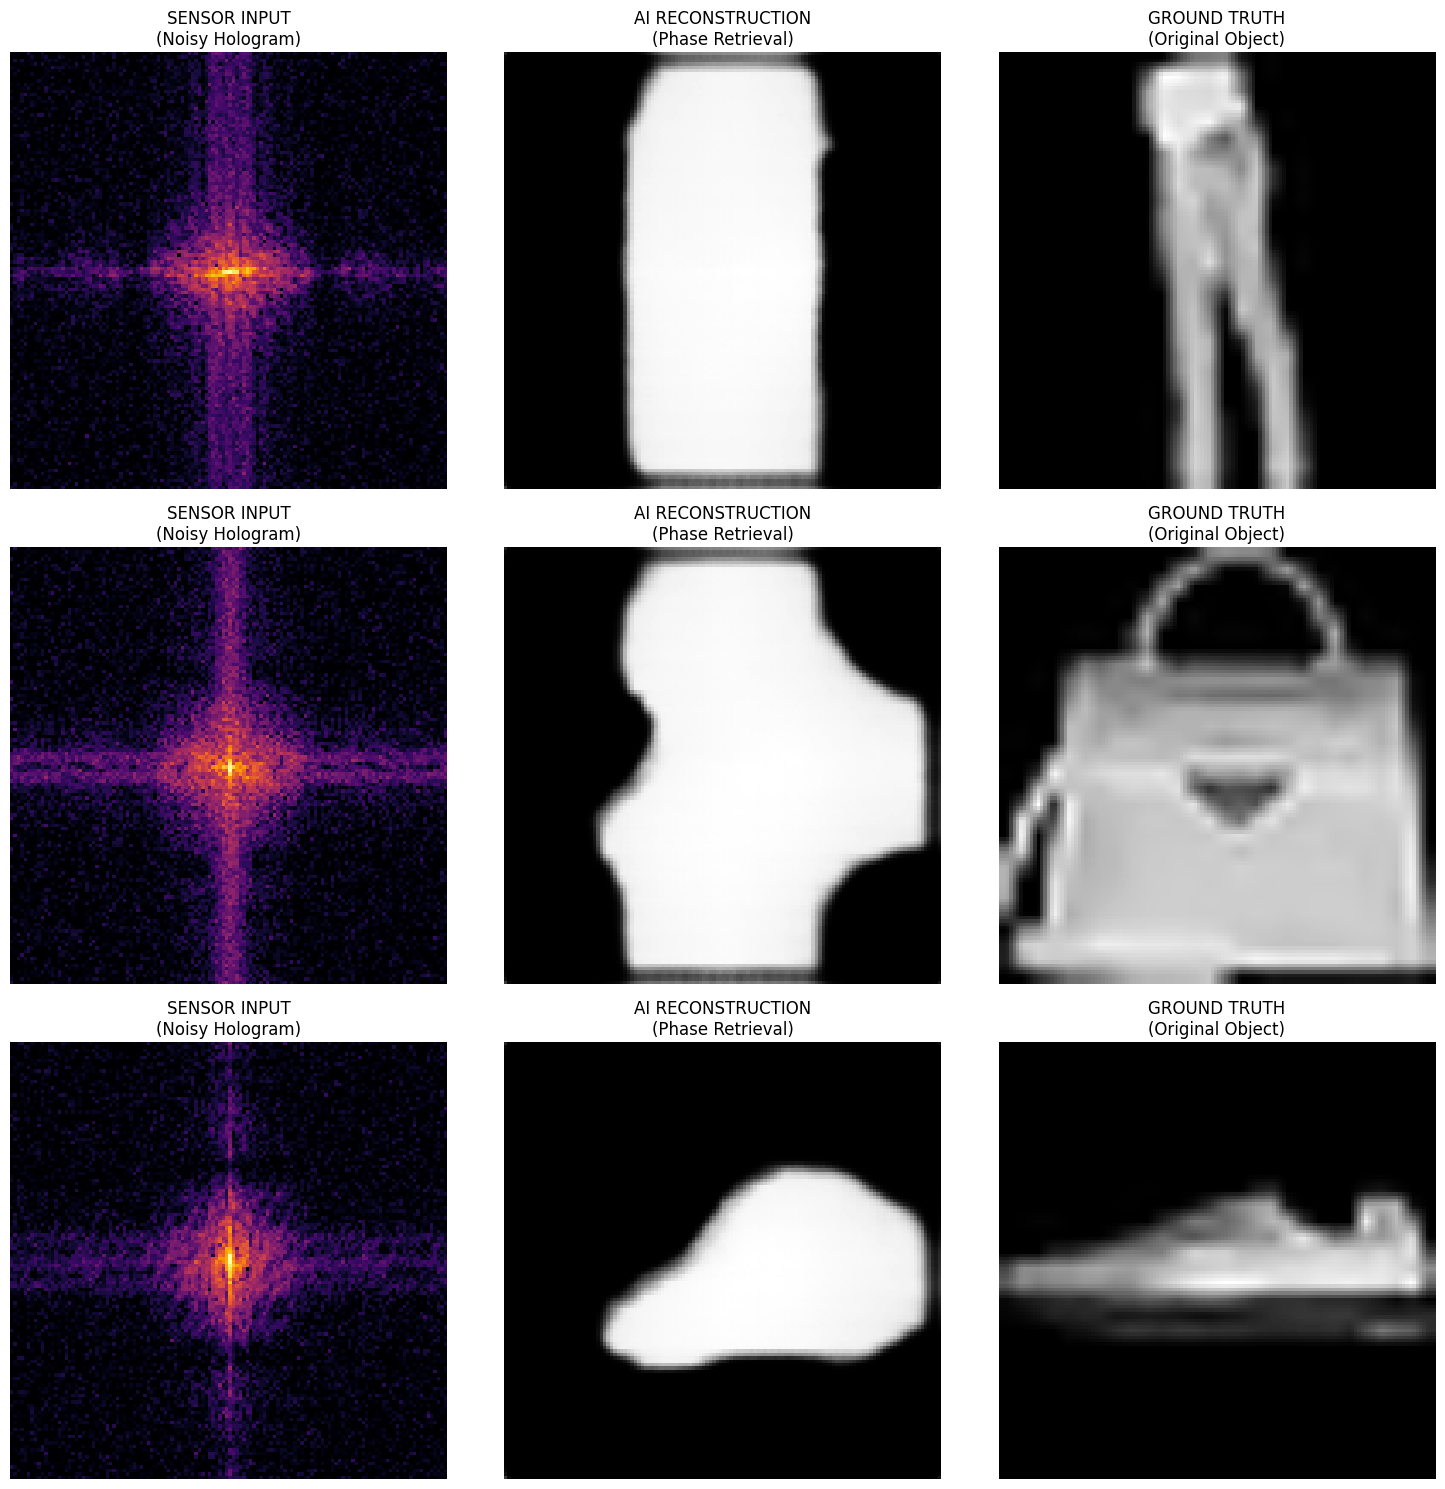

In [13]:
# ==============================================================================
# CELL 8: LIVE INFERENCE & VISUALIZATION
# ==============================================================================

def visualize_results(model, dataset, num_samples=3):
    """
    Runs the model on unseen data and visualizes the Phase Retrieval process.
    """
    print("[SYSTEM]: Generating Holographic Reconstructions...")

    # 1. Get a single batch of data from the pipeline
    # The iterator returns (Input_Holograms, Target_Images)
    example_batch = next(iter(dataset))
    inputs_holo, targets_real = example_batch

    # 2. Run the U-Net (Inference)
    # The model takes the Noisy Holograms and predicts the Clean Objects
    predictions = model.predict(inputs_holo)

    # 3. Plot the Results
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # COLUMN 1: The Input (What the Sensor Sees)
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.title("SENSOR INPUT\n(Noisy Hologram)")
        plt.imshow(inputs_holo[i, :, :, 0], cmap='inferno')
        plt.axis('off')

        # COLUMN 2: The AI Output (The Reconstruction)
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.title("AI RECONSTRUCTION\n(Phase Retrieval)")
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

        # COLUMN 3: The Ground Truth (The Physical Object)
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.title("GROUND TRUTH\n(Original Object)")
        plt.imshow(targets_real[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# RUN THE VISUALIZATION
visualize_results(model, train_dataset, num_samples=3)

## 5. Conclusion & Future Work
The results demonstrate that a Deep Learning model can successfully invert the Fourier Transform in the presence of noise, recovering structural details invisible to the human eye.
* **Application:** This pipeline can be deployed for real-time biological microscopy (bacteria identification) or industrial defect detection without lenses.
* **Future Work:** Integration with **Google Vertex AI Vector Search** for large-scale technical manual retrieval.